In [27]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import pandas as pd
import os

# Set CUDA_LAUNCH_BLOCKING
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load data

In [29]:
import numpy as np

a = np.array([1, 2, 3])
np.array(a > 1, dtype=int)

array([0, 1, 1])

In [30]:
result_dir = "/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/"
peak_selection_spec_dir = os.path.join(
    "2d_peak_selection",
    "exp_wdice_per_image_combo_two_channel_exp_log_lr001_wdice1_dh5",
)
conf_exp_dir = "20240627_135819294288"
conf_exp_full_dir = os.path.join(result_dir, peak_selection_spec_dir, conf_exp_dir)
test_df = pd.read_csv(
    os.path.join(conf_exp_full_dir, "conf_model_results", "test_results.csv")
)

FileNotFoundError: [Errno 2] No such file or directory: '/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_two_channel_exp_log_lr001_wdice1_dh5/20240627_135819294288/conf_model_results/test_results.csv'

# Eval

## Generate eval if not already exists

In [31]:
# Load config
from peak_detection_2d.config.config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg_path = [
    os.path.join(conf_exp_full_dir, f)
    for f in os.listdir(conf_exp_full_dir)
    if f.endswith(".yaml")
]
cfg.merge_from_file(cfg_path[0])

In [32]:
# Load model
%autoreload 2
best_model_name = "bst_model_0.8537.pt"
best_model_path = os.path.join(conf_exp_full_dir, "conf_model_backups", best_model_name)

from peak_detection_2d.model.build_model import build_model
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
conf_model = build_model(cfg.CONFMODEL)
checkpoint = torch.load(best_model_path, map_location=DEVICE)
conf_model.load_state_dict(checkpoint["model_state_dict"])
conf_model.to(DEVICE)

<All keys matched successfully>

CNNEncoderRegressor(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(32, 64, kernel_size=

In [33]:
# Load IMAGE dataset
from peak_detection_2d.dataset.dataset import (
    MultiHDF5_MaskDataset,
    build_transformation,
)

cfg_dataset = cfg.DATASET
cfg_segmodel = cfg.MODEL
h5_path = os.path.join(
    cfg_dataset.RAW_DATA_PATH,
    cfg_dataset.ACTIVATION_PATH,
    cfg_dataset.MODEL_DATA_PATH,
)
# Load data
hdf5_files = [
    os.path.join(h5_path, f) for f in os.listdir(h5_path) if f.endswith(".h5")
]

transformation = build_transformation(cfg_dataset)
if cfg_dataset.INPUT_CHANNELS == ["log"]:
    cfg_dataset.ONLY_LOG_CHANNEL = True
logging.info("Dataset channels: %d", cfg_segmodel.PARAMS.IN_CHANNELS)

# Create the dataset
dataset = MultiHDF5_MaskDataset(hdf5_files, transforms=transformation)


# Split the dataset into training and testing sets
train_val_dataset, test_image_dataset = dataset.split_dataset(
    train_ratio=cfg_dataset.TRAIN_VAL_SIZE, seed=cfg_dataset.RANDOM_STATE
)
train_image_dataset, val_image_dataset = train_val_dataset.split_dataset(
    train_ratio=cfg_dataset.TRAIN_SIZE, seed=cfg_dataset.RANDOM_STATE
)
train_image_dataloader = torch.utils.data.DataLoader(
    train_image_dataset, batch_size=128, shuffle=False
)
val_image_dataloader = torch.utils.data.DataLoader(
    val_image_dataset, batch_size=128, shuffle=False
)
test_image_dataloader = torch.utils.data.DataLoader(
    test_image_dataset, batch_size=128, shuffle=False
)

2024-06-27 14:28:52,725 - root - INFO - Dataset channels: 2


In [34]:
# Load seg model
best_seg_model_name = "bst_model_0.7765.pt"
best_seg_model_path = os.path.join(
    result_dir, peak_selection_spec_dir, "model_backups", best_seg_model_name
)

from peak_detection_2d.model.build_model import build_model

seg_model = build_model(cfg.MODEL)
seg_checkpoint = torch.load(best_seg_model_path, map_location=DEVICE)
seg_model.load_state_dict(seg_checkpoint["model_state_dict"])
seg_model.to(DEVICE)

<All keys matched successfully>

UNET(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(32,

In [35]:
from peak_detection_2d.model.conf_model import (
    inference_and_sum_intensity,
)

test_df = inference_and_sum_intensity(
    data_loader=test_image_dataloader,
    model=seg_model,
    device=DEVICE,
    calc_score="conf_model",
    conf_model=conf_model,
    exp=cfg.DATASET.ONLY_LOG_CHANNEL,
)
test_df.to_csv(
    os.path.join(conf_exp_full_dir, "conf_model_results", "test_results.csv"),
    index=False,
)

In [36]:
from peak_detection_2d.model.conf_model import (
    inference_and_sum_intensity,
)

val_df = inference_and_sum_intensity(
    data_loader=val_image_dataloader,
    model=seg_model,
    device=DEVICE,
    calc_score="conf_model",
    conf_model=conf_model,
    exp=cfg.DATASET.ONLY_LOG_CHANNEL,
)
val_df.to_csv(
    os.path.join(conf_exp_full_dir, "conf_model_results", "val_results.csv"),
    index=False,
)

In [19]:
from peak_detection_2d.model.conf_model import (
    inference_and_sum_intensity,
)

train_df = inference_and_sum_intensity(
    data_loader=train_image_dataloader,
    model=seg_model,
    device=DEVICE,
    calc_score="conf_model",
    conf_model=conf_model,
    exp=cfg.DATASET.ONLY_LOG_CHANNEL,
)
train_df.to_csv(
    os.path.join(conf_exp_full_dir, "conf_model_results", "train_results.csv"),
    index=False,
)

## Eval of test/val variance

In [37]:
# Get metric on test dataset
from sklearn.metrics import mean_absolute_error

logging.info(
    "test set mae: %s", mean_absolute_error(test_df["out_score"], test_df["wiou"])
)
logging.info(
    "val set mae: %s", mean_absolute_error(val_df["out_score"], val_df["wiou"])
)
# logging.info(
#     "train set mae: %s", mean_absolute_error(train_df["out_score"], train_df["wiou"])
# )

2024-06-27 14:30:24,080 - root - INFO - test set mae: 0.17910503541142142
2024-06-27 14:30:24,083 - root - INFO - val set mae: 0.16673536926019739


Here the train and val set split is different from the confidence datset, hence there is a difference in the the val of 0.078

In [38]:
from peak_detection_2d.utils import plot_confidence_distr

plot_confidence_distr(
    test_df, save_dir=os.path.join(conf_exp_full_dir, "conf_model_results")
)

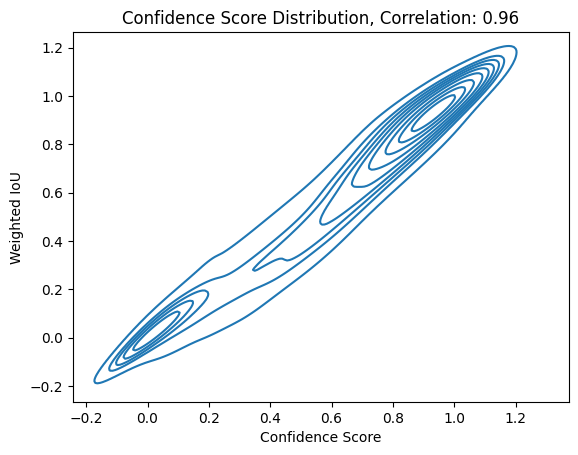

In [27]:
plot_confidence_distr(val_df, save_dir=None)

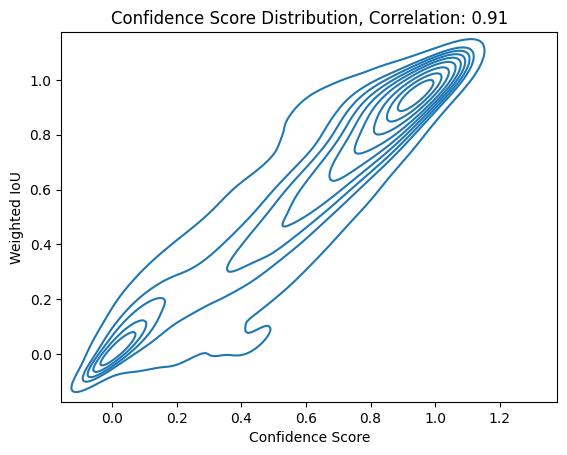

In [17]:
plot_confidence_distr(train_df, save_dir=None)

In [39]:
import plotly.express as px

test_df["label_sum_intensity_log"] = np.log10(test_df["label_sum_intensity"] + 1)
px.scatter(
    data_frame=test_df,
    x="out_score",
    y="wiou",
    color="label_sum_intensity_log",
    hover_data=[
        "pept_mz_rank",
        test_df.index,
    ],
)

2024-06-26 08:57:48,077 - peak_detection_2d.utils - INFO - Confidence score: 0.3961251676082611


2024-06-26 08:57:48,107 - peak_detection_2d.utils - INFO - Masked area 1232.0
2024-06-26 08:57:48,109 - peak_detection_2d.utils - INFO - Masked intensity sum 2438.96
2024-06-26 08:57:48,110 - peak_detection_2d.utils - INFO - Pred masked intensity sum 2414.10


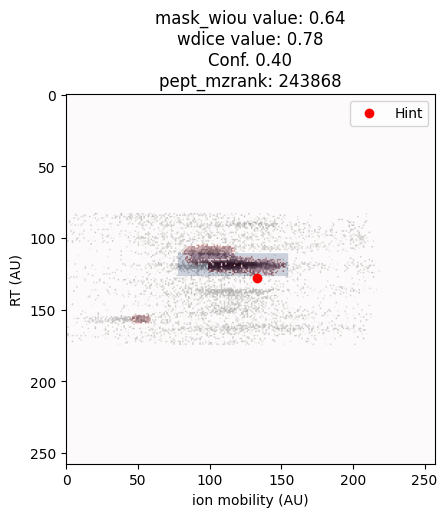

In [71]:
import matplotlib.pyplot as plt
from peak_detection_2d.utils import plot_sample_predictions

data_idx = 443

plot_sample_predictions(
    dataset=test_image_dataset,
    model=model,
    conf_model=conf_model,
    sample_indices=[data_idx],
    device=DEVICE,
    label="mask",
    save_dir=None,
    use_hint=False,
    zoom_in=False,
    metric_list=["mask_wiou", "wdice"],
)

<Axes: >

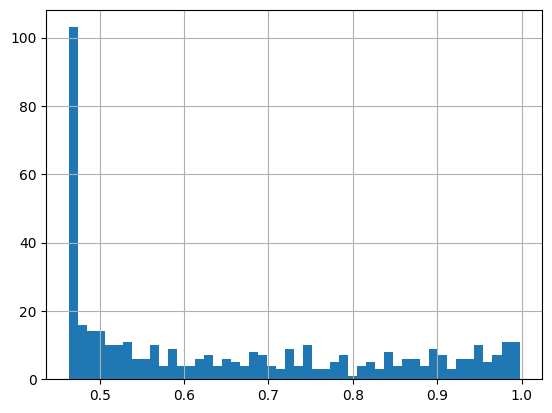

In [23]:
test_df.loc[test_df["wiou"] <= 0.1]["out_score"].hist(bins=50)

<Axes: >

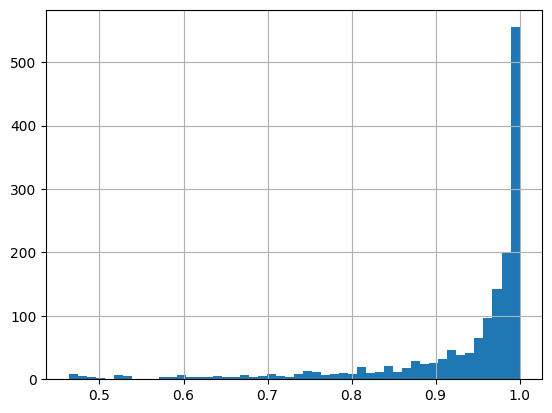

In [24]:
test_df.loc[test_df["wiou"] >= 0.9]["out_score"].hist(bins=50)

<Axes: >

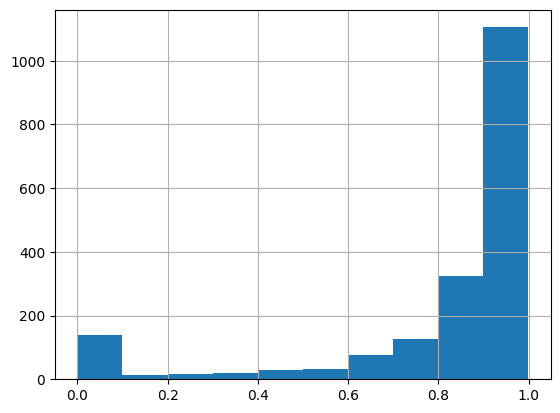

In [40]:
test_df.loc[test_df["out_score"] > 0.6, "wiou"].hist()

## Correlation of sum_intensitys

2024-06-27 14:31:03,619 - result_analysis.result_analysis - INFO - Reference shape: (31029, 32)


Data:  Intensity_log sum_intensity_log , slope =  0.872 , intercept =  0.222 , PearsonR =  0.849 , SpearmanR =  0.837


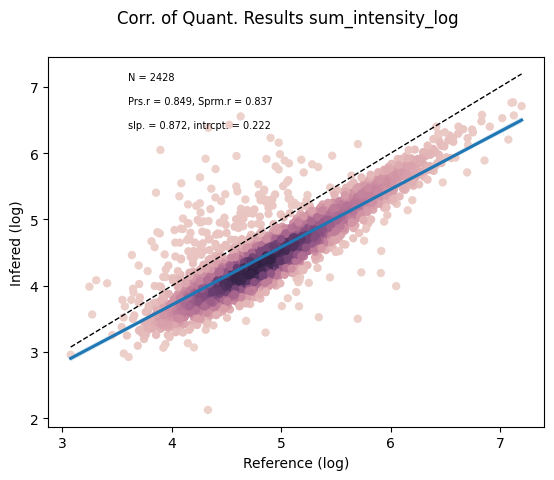

In [40]:
from result_analysis.result_analysis import SBSResult
import pandas as pd

maxquant_merge = pd.read_pickle(
    os.path.join(result_dir, "maxquant_result_merged_cleaned.pkl")
)
sbs_ims_result = SBSResult(
    maxquant_ref_df=maxquant_merge,
    maxquant_merge_df=maxquant_merge,
    maxquant_exp_df=None,
    # sum_raw=test_df.loc[test_df["label_sum_intensity_log"] >= 4],
    sum_raw=val_df.loc[val_df["out_score"] >= 0.5],
    # sum_gaussian=train_label_df,
    ims=True,
)
sbs_ims_result.plot_intensity_corr(
    ref_col="Intensity", inf_col="sum_intensity", contour=False
)

## Samples with low IoU

<Axes: xlabel='log_label_intensity', ylabel='log_pred_intensity'>

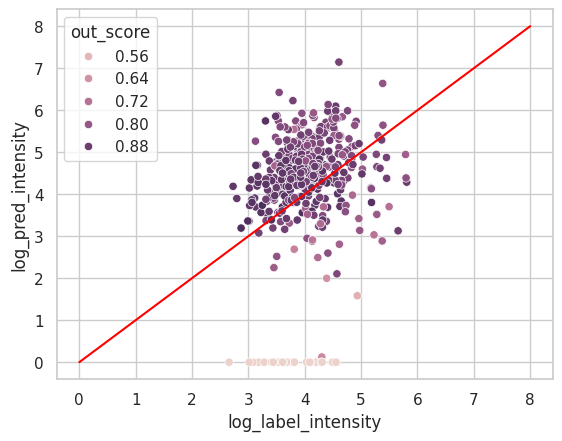

In [82]:
from matplotlib import cm
from pyparsing import col


# set grid in the background
sns.set(style="whitegrid")
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_label_intensity",
    y="log_pred_intensity",
    hue="out_score",
    hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)
plt.plot([0, 8], [0, 8], color="red")

<Axes: xlabel='log_pred_intensity', ylabel='out_score'>

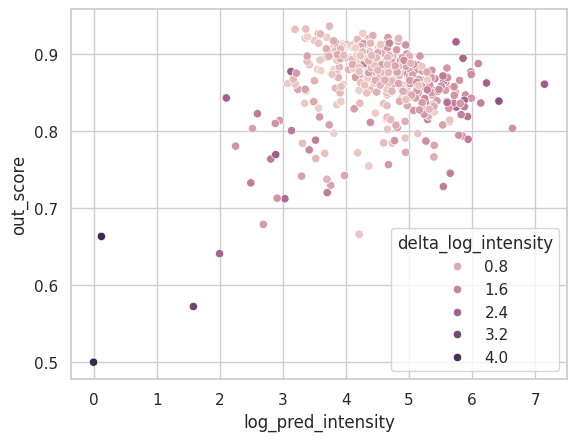

In [91]:
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_pred_intensity",
    y="out_score",
    hue="delta_log_intensity",
    # hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)

<Axes: xlabel='losses', ylabel='out_score'>

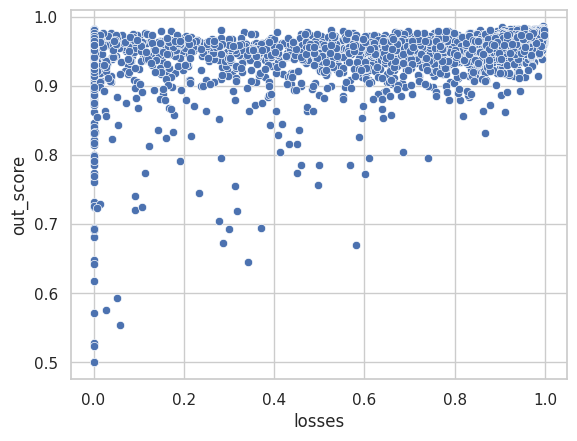

In [111]:
# Evaluating miscalibration
sns.scatterplot(
    # data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    data=test_all_df,
    x="losses",
    y="out_score",
    # hue="delta_log_intensity",
    # hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)

In [ ]:
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_label_intensity",
    y="log_pred_intensity",
    size="out_score",
    # color=cm.get_cmap("coolwarm"),
)

In [80]:
from peak_detection_2d.utils import plot_sample_predictions
import pandas as pd

ind_all_wiou = pd.DataFrame(ind_all_wiou)
# get indices of the top 10 worst performing images
worst_performing_images = ind_all_wiou["losses"].sort_values(ascending=True).index[:10]

# Plot sample predictions
plot_sample_predictions(
    test_image_dataset,
    model=bst_model,
    sample_indices=worst_performing_images,
    # n = 10,
    # save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    save_dir=os.path.join(peak_selection_dir, "sample_predictions_lowest_wiou"),
)

2024-06-06 16:19:17,937 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-06 16:19:17,938 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 2, 258, 258])
2024-06-06 16:19:17,964 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 258, 258])
2024-06-06 16:19:17,965 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding

In [82]:
best_performing_images = (
    ind_all_wiou["losses"].sort_values(ascending=False).index[50:60]
)

# Plot sample predictions
plot_sample_predictions(
    test_image_dataset,
    model=bst_model,
    sample_indices=best_performing_images,
    # n = 10,
    # save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    save_dir=os.path.join(peak_selection_dir, "sample_predictions_highest_wiou"),
)

2024-06-06 16:21:26,036 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-06 16:21:26,037 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 2, 258, 258])
2024-06-06 16:21:26,038 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 258, 258])
2024-06-06 16:21:26,039 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding

In [84]:
from peak_detection_2d.utils import plot_per_image_metric_distr

plot_per_image_metric_distr(
    ind_all_wiou["losses"], "Weighted_IoU", save_dir=peak_selection_dir
)
plot_per_image_metric_distr(
    ind_all_wdice["losses"], "Weighted_Dice", save_dir=peak_selection_dir
)

25%: 0.14
50%: 0.78
75%: 0.95
25%: 0.25
50%: 0.88
75%: 0.97


In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

31

31

In [20]:
%autoreload 2
from peak_detection_2d.utils import plot_sample_predictions

# Plot sample predictions
plot_sample_predictions(
    test_image_dataset,
    model=bst_model,
    sample_indices=[1420, 2409, 1483, 2101,  68, 3003, 2973, 2182, 2311, 2606],
    #n = 10,
    #save_dir=None,
    metric_list = ["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in = False,
    label = 'mask',
    save_dir=os.path.join(peak_selection_dir, "sample_predictions"),
)

2024-06-03 16:25:35,331 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-03 16:25:35,332 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 1, 178, 178])
2024-06-03 16:25:35,333 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 178, 178])
2024-06-03 16:25:35,334 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding